# This is a tool for looking at HDX/MS data, LacI structure, and mutational phenotypes for particular LacI peptides in one or more functional states.

![LacI peptides and structure.](lacI_diagram_table.png)

### First choose the state(s).

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pytraj as pt
import nglview as nv
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import seaborn as sns
import ipywidgets as widgets
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter


print('Choose from the following functional states: ')
CBwidget_IPTG = widgets.Checkbox(description = 'IPTG, an inducer molecule', value=True, disabled=False)
CBwidget_ONPF = widgets.Checkbox(description = 'ONPF, an anti-inducer molecule', value=True, disabled=False)
CBwidget_APO = widgets.Checkbox(description = 'APO protein', value=False, disabled=False)
CBwidget_DNA = widgets.Checkbox(description = 'operator DNA', value=True, disabled=False)
CBwidget_TMG = widgets.Checkbox(description = 'TMG, an inducer molecule', value=False, disabled=False)
CBwidget_ONPFDNA = widgets.Checkbox(description = 'ONPF and operator DNA', value=False, disabled=False)

display(CBwidget_IPTG, CBwidget_ONPF, CBwidget_APO, CBwidget_DNA, CBwidget_TMG, CBwidget_ONPFDNA)

Choose from the following functional states: 


Checkbox(value=True, description='IPTG, an inducer molecule')

Checkbox(value=True, description='ONPF, an anti-inducer molecule')

Checkbox(value=False, description='APO protein')

Checkbox(value=True, description='operator DNA')

Checkbox(value=False, description='TMG, an inducer molecule')

Checkbox(value=False, description='ONPF and operator DNA')

### Next, choose a peptide.

In [2]:
states_list = []

if CBwidget_IPTG.value == True:
    states_list.append('IPTG')
if CBwidget_ONPF.value == True:
    states_list.append('ONPF')
if CBwidget_APO.value == True:
    states_list.append('APO')
if CBwidget_DNA.value == True:
    states_list.append('DNA')
if CBwidget_TMG.value == True:
    states_list.append('TMG')
if CBwidget_ONPFDNA.value == True:
    states_list.append('ONPFDNA')

print('Chosen states:'); print(*states_list)

compiled_file = pd.ExcelFile('20200922_compiled_rates.xlsx')
EOF_file = pd.ExcelFile('error_of_fit.xlsx')

states_dict = {}
peptide_states_list = ['peptide']
for state in states_list:
    states_dict[state] = pd.read_excel(compiled_file, state)
    peptide_states_list.append(state)
    
EOF_df = pd.read_excel(EOF_file, usecols = peptide_states_list)

# Make dictionaries to organize mutation information
MH_dict = {}
with open("MH_groups.txt") as file:
    for line in file:
        (key, val) = line.split()
        MH_dict[int(key)] = val

mutation_dict = {}
with open("single_mutants.txt") as file:
    for line in file:
        (key, val) = line.split()
        mutation_dict[key] = val
        
MHdescriptions_dict = {}
with open("MHgroups_descriptions.txt") as file:
    for line in file:
        (key, val) = line.split(':')
        MHdescriptions_dict[key] = val
        
single_state_dict = states_dict.get(states_list[0])
all_peptides = single_state_dict[['peptide']].values.tolist()
all_peptides_2 = []
first_res = single_state_dict[['first_res']].values.tolist()
index = 0

while index < len(all_peptides):
    current_first_res = str(int(first_res[index][0]))
    all_peptides_2.append(current_first_res + ' - ' + all_peptides[index][0])
    index = index + 1

DDwidget = widgets.Dropdown(
    options = all_peptides_2,
    value = '72 - ALHAPSQIVAA',
    description = 'Peptide 1:',
    disabled = False,
)

DDwidget2 = widgets.Dropdown(
    options = all_peptides_2,
    value = '109 - AAVHNL',
    description = 'Peptide 2:',
    disabled = False,
)

display(DDwidget)
display(DDwidget2)

Chosen states:
IPTG ONPF DNA


Dropdown(description='Peptide 1:', index=3, options=('63 - LIGVA', '72 - ALHAP', '72 - ALHAPSQIVA', '72 - ALHA…

Dropdown(description='Peptide 2:', index=12, options=('63 - LIGVA', '72 - ALHAP', '72 - ALHAPSQIVA', '72 - ALH…

## Map the peptides onto the protein structure for the chosen states and peptides.

In [3]:
peptide_input1 = str(DDwidget.value)
peptide_input1 = peptide_input1.split()[-1]

peptide_input2 = str(DDwidget2.value)
peptide_input2 = peptide_input2.split()[-1]

list_states = states_dict.keys()
peptide_dict1 = dict.fromkeys(list_states, peptide_input1)
peptide_dict2 = dict.fromkeys(list_states, peptide_input2)

############

def getIndexes(dfObj, value):
    listOfPos = []
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    return listOfPos

############

for key in peptide_dict1:
    peptide1_df = states_dict[key]
    peptide1_df = peptide1_df[peptide1_df["peptide"] == peptide_input1]
    peptide1_df = peptide1_df[['first_res','last_res','peptide']]
    peptide_dict1[key] = peptide1_df
    
peptide1_first_res = int(peptide1_df['first_res'])
peptide1_last_res = int(peptide1_df['last_res'])
print('Peptide 1: ' + peptide_input1 + ", residues " + str(peptide1_first_res) + "-" + str(peptide1_last_res))

column_vals = []

for key in peptide_dict1:
    peptide_file = pd.ExcelFile('~/Dropbox/Research/Data/HDX/20200816/20200819_fitting/' + str(peptide1_first_res) + 
                                '_' + str(peptide1_last_res) + '_' + peptide_input1 + '_fitting.xlsx')
    raw_df = pd.read_excel(peptide_file, 'Peptide SD', nrows = 15)

    listOfPositions = getIndexes(raw_df, key)
    for i in range(len(listOfPositions)):
        temp_string = (listOfPositions[i][1])
        position = int(temp_string[-2:])
        column_vals.append(position) # columns in spreadsheet corresponding to data label

peptide1_exchange = {}
for element in column_vals:
    for key in peptide_dict1.keys():
        if key.lower() == (raw_df.iloc[2][element]).lower():
            peptide1_exchange[key] = list(raw_df.iloc[4:13,element+2])

############

for key in peptide_dict2:
    peptide2_df = states_dict[key]
    peptide2_df = peptide2_df[peptide2_df["peptide"] == peptide_input2]
    peptide2_df = peptide2_df[['first_res','last_res','peptide']]
    peptide_dict2[key] = peptide1_df
    
peptide2_first_res = int(peptide2_df['first_res'])
peptide2_last_res = int(peptide2_df['last_res'])
print('Peptide 2: ' + peptide_input2 + ", residues " + str(peptide2_first_res) + "-" + str(peptide2_last_res))

column_vals = []

for key in peptide_dict1:
    peptide_file = pd.ExcelFile('~/Dropbox/Research/Data/HDX/20200816/20200819_fitting/' + str(peptide2_first_res) + 
                                '_' + str(peptide2_last_res) + '_' + peptide_input2 + '_fitting.xlsx')
    raw_df = pd.read_excel(peptide_file, 'Peptide SD', nrows = 15)

    listOfPositions = getIndexes(raw_df, key)
    for i in range(len(listOfPositions)):
        temp_string = (listOfPositions[i][1])
        position = int(temp_string[-2:])
        column_vals.append(position) # columns in spreadsheet corresponding to data label

peptide2_exchange = {}
for element in column_vals:
    for key in peptide_dict2.keys():
        if key.lower() == (raw_df.iloc[2][element]).lower():
            peptide2_exchange[key] = list(raw_df.iloc[4:13,element+2])

# This section controls the structure widget.

# view = nv.NGLWidget()
traj = pt.load('2p9h_REDO.pdb')
view = nv.show_pytraj(traj)
view.add_surface(str(peptide1_first_res+2) + "-" + str(peptide1_last_res), color = 'orange', 
                 opacity='0.5', wireframe=False)
view.add_ball_and_stick(str(peptide1_first_res+2) + "-" + str(peptide1_last_res))
view.add_surface(str(peptide2_first_res+2) + "-" + str(peptide2_last_res), color = 'lightblue', 
                 opacity='0.5', wireframe=False)
view.add_ball_and_stick(str(peptide2_first_res+2) + "-" + str(peptide2_last_res))
view.background = "white"
# view.add_surface('74-81', color = 'orange', opacity='0.9', wireframe=True)
# view.add_ball_and_stick('246-255')


# view.add_representation('line', selection='water') # uncomment this line to see solvent
view._set_size('800px', '600px')
mat = [59.476009917035874 ,66.10295214971443, -76.02228809508843, 0,
       -55.56959630110223, 95.16365469618486, 39.27191257844691, 0,
       84.029807431962, 16.14505706800799, 79.77915091670029, 0, 
       -22.46560287475586, 17.614827632904053, -10.28352165222168, 1]
view._set_camera_orientation(mat)
print('''
PDB ID: 2P9H (wild-type LacI core domain + IPTG). 
Oriented with the C-terminal subdomain at the top.

Use the mouse to move the structure. 
Double-click for full-screen. Type "R" to zoom out, "I" to rotate, and "K" to rock.
NGLViewer, an amazing tool: H Nguyen, DA Case and AS Rose, Bioinformatics, 2017. doi:10.1093/bioinformatics/btx789
''')
print('Peptide ' + peptide_input1 + ', residues ' + str(peptide1_first_res+2) + "-" + str(peptide1_last_res) + 
      ', shown as orange surface and sticks.')
print('Peptide ' + peptide_input2 + ', residues ' + str(peptide2_first_res+2) + "-" + str(peptide2_last_res) + 
      ', shown as blue surface and sticks.')
view

Peptide 1: ALHAPSQIVAA, residues 72-82
Peptide 2: AAVHNL, residues 109-114

PDB ID: 2P9H (wild-type LacI core domain + IPTG). 
Oriented with the C-terminal subdomain at the top.

Use the mouse to move the structure. 
Double-click for full-screen. Type "R" to zoom out, "I" to rotate, and "K" to rock.
NGLViewer, an amazing tool: H Nguyen, DA Case and AS Rose, Bioinformatics, 2017. doi:10.1093/bioinformatics/btx789

Peptide ALHAPSQIVAA, residues 74-82, shown as orange surface and sticks.
Peptide AAVHNL, residues 111-114, shown as blue surface and sticks.


NGLWidget()

## Plot H/D exchange functions as uptake plots for each peptide for each state.

ALHAPSQIVAA
IPTG
[3.11154757e+00 7.85981230e-01 1.11737928e+00 8.14413078e-01
 3.12708589e-02 2.50113732e-04 4.00000000e+00]
Residuals sum of squares:
9.015837007990749
Total sum of squares:
3.308877809733942
R2 value
-1.7247415971264553

ALHAPSQIVAA
ONPF
[1.53795739e+00 3.52744442e+00 2.10498964e+00 6.34236361e-02
 6.34162628e-02 2.15040245e-04 4.00000000e+00]
Residuals sum of squares:
9.28689631358195
Total sum of squares:
13.125407605572605
R2 value
0.2924489210042477

ALHAPSQIVAA
DNA
[2.22558406e+00 2.19297486e+00 7.95422335e-01 8.93810679e-02
 8.94354028e-02 1.92556562e-04 4.00000000e+00]
Residuals sum of squares:
9.090189761205622
Total sum of squares:
3.222164863816146
R2 value
-1.8211435930189266

AAVHNL
IPTG
[2.54051803e+00 5.31116871e-11 1.97210837e+00 7.05355625e-01
 1.00000000e-01 2.52619964e-04 2.00000000e+00]
Residuals sum of squares:
4.703431937950543
Total sum of squares:
5.3479554202966195
R2 value
0.1205177365353447

AAVHNL
ONPF
[2.35834269e+00 4.30346801e-01 3.999994

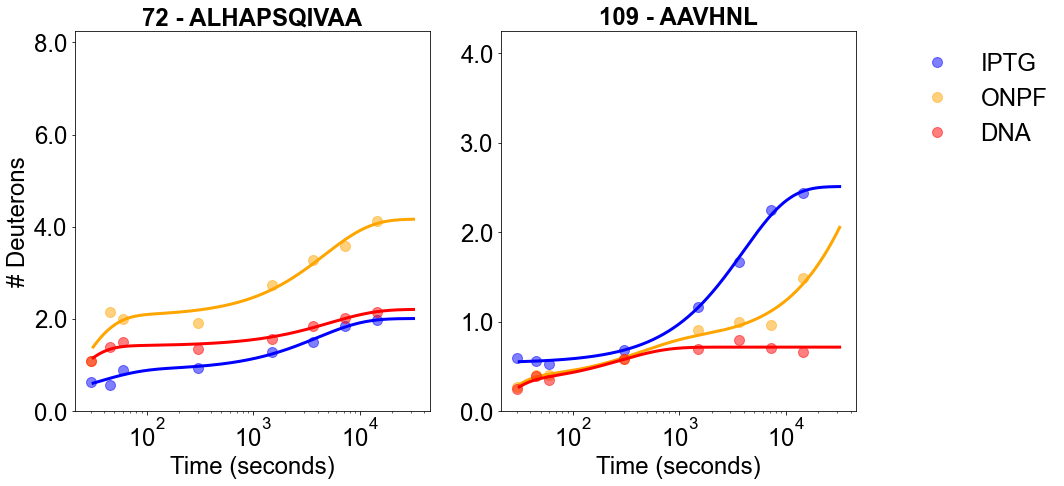

In [4]:
# fitting

def exchange_fit(x, a, b, c, d, e, f, g):
    max_protons = a + b + c + g - 2 - num_prolines
    d > e
    e > f
    d > f
    return max_protons - a * np.exp(-d * x) - b * np.exp(-e * x) - c * np.exp(-f * x) - g

def exchange_fit_low(x, b, c, e, f, g):
    max_protons = b + c + g - 2 - num_prolines
    e > f
    return max_protons - b * np.exp(-e * x) - c * np.exp(-f * x) - g

timepoints = [0, 30, 45, 60, 300, 1500, 3600, 7200, 14400]
trialT = np.logspace(1.5, 4.5, 10000)

num_prolines = peptide_input1[2:].count('P')
max_protons = len(peptide_input1) - 2 - num_prolines

peptide1_fits = {}
# SSR_p1_dict = {}

for key in peptide1_exchange:
    p1_index = 0
    peptide1_tps = []
    peptide1_ex = []
    for tp in peptide1_exchange.get(key):
        if not math.isnan(float(tp)):
            peptide1_tps.append(timepoints[p1_index])
            peptide1_ex.append(float(tp))
        p1_index = p1_index + 1
        
    if peptide1_ex[-1] > .5:
        
        popt, pcov = curve_fit(f = exchange_fit, xdata = peptide1_tps, ydata = peptide1_ex,
                               bounds = (0, [max_protons, max_protons, max_protons, 1, .1, .01, max_protons]),
                               maxfev = 100000)
        exchange_peptide1 = exchange_fit(trialT, *popt)
        perr = np.sqrt(np.diag(pcov))
        peptide1_fits[key] = exchange_peptide1
        
    else:

        popt, pcov = curve_fit(f = exchange_fit_low, xdata = peptide1_tps, ydata = peptide1_ex,
                               bounds = (0, [max_protons, max_protons, .1, .01, max_protons]),
                               maxfev = 100000)
        exchange_peptide1 = exchange_fit_low(trialT, *popt)
        perr = np.sqrt(np.diag(pcov))
        peptide1_fits[key] = exchange_peptide1
        
    print(peptide_input1)
    print(key)
    print(popt)
    
    residuals = peptide1_ex - exchange_fit(np.array(peptide1_tps), *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((peptide1_ex-np.mean(peptide1_ex))**2)
    r_squared = 1 - (ss_res / ss_tot)

    print("Residuals sum of squares:")
    print(ss_res)
    print("Total sum of squares:")
    print(ss_tot)
    print("R2 value")
    print(r_squared)
    print()


num_prolines = peptide_input2[2:].count('P')
max_protons = len(peptide_input2) - 2 - num_prolines
    
peptide2_fits = {}

for key in peptide2_exchange:
    p2_index = 0
    peptide2_tps = []
    peptide2_ex = []
    for tp in peptide2_exchange.get(key):
        if not math.isnan(float(tp)):
            peptide2_tps.append(timepoints[p2_index])
            peptide2_ex.append(float(tp))
        p2_index = p2_index + 1
        
    if peptide2_ex[-1] > .5:
        
        popt, pcov = curve_fit(f = exchange_fit, xdata = peptide2_tps, ydata = peptide2_ex,
                               bounds = (0, [max_protons, max_protons, max_protons, 1, .1, .01, max_protons]),
                               maxfev = 100000)
        exchange_peptide2 = exchange_fit(trialT, *popt)
        perr = np.sqrt(np.diag(pcov))
        peptide2_fits[key] = exchange_peptide2
        
    else:
        
        popt, pcov = curve_fit(f = exchange_fit_low, xdata = peptide2_tps, ydata = peptide2_ex,
                               bounds = (0, [max_protons, max_protons, .1, .01, max_protons]),
                               maxfev = 100000)
        exchange_peptide2 = exchange_fit_low(trialT, *popt)
        perr = np.sqrt(np.diag(pcov))
        peptide2_fits[key] = exchange_peptide2
    
    print(peptide_input2)
    print(key)
    print(popt)
    
    residuals = peptide2_ex - exchange_fit(np.array(peptide2_tps), *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((peptide2_ex-np.mean(peptide2_ex))**2)
    r_squared = 1 - (ss_res / ss_tot)

    print("Residuals sum of squares:")
    print(ss_res)
    print("Total sum of squares:")
    print(ss_tot)
    print("R2 value")
    print(r_squared)
    print()

# plotting
    
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 24
       }
axes = {'titlesize' : 24,
        'titleweight' : 'bold',
        'labelsize' : 24
       }

plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('lines', lw = 3)
color_dict = {
    'IPTG' : 'blue',
    'ONPF' : 'orange',
    'APO' : 'green',
    'DNA' : 'red',
    'TMG' : 'gray',
    'ONPFDNA' : 'purple'
    }

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

for key in peptide1_exchange:
    ax1.plot(timepoints, peptide1_exchange.get(key), 'o', label = key, markersize = 10, alpha = 0.5, 
             color = color_dict.get(key))
    ax1.plot(trialT, peptide1_fits.get(key), '-', color = color_dict.get(key))
#     ax1.fill_between(trialT, peptide1_fits.get(key) + SSR_p1_dict.get(key), 
#                      peptide1_fits.get(key) - SSR_p1_dict.get(key), 
#                      alpha=0.2, color = color_dict.get(key))
for key in peptide2_exchange:
    ax2.plot(timepoints, peptide2_exchange.get(key), 'o', label = key, markersize = 10, alpha = 0.5,
             color = color_dict.get(key))
    ax2.plot(trialT, peptide2_fits.get(key), '-', color = color_dict.get(key))

ax1.set_ylabel('# Deuterons')
ax1.set_xlabel('Time (seconds)')
ax2.set_xlabel('Time (seconds)')
ax1.set_title(str(peptide1_first_res) + ' - ' + peptide_input1)
ax2.set_title(str(peptide2_first_res) + ' - ' + peptide_input2)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_ylim(0, len(peptide_input1) - 2 - peptide_input1[2:].count('P') + 0.25)
ax2.set_ylim(0, len(peptide_input2) - 2 - peptide_input2[2:].count('P')+ 0.25)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.legend(frameon = False, bbox_to_anchor = (1.6, 1))
plt.show()

### Compile mutational phenotype data for Peptide 1.

In [ ]:
# This section controls the mutation information.

peptide1_range = range(peptide1_first_res, peptide1_last_res + 1, 1)

print('''
-------- Mutational phenotype data from Markiewicz et al., J. Mol Biol., 1994 --------
''')
print('Peptide 1: ' + peptide_input1)

peptide_index = 0
res_label_value = []
AA_value = []
heatmap_value = []

aa = list("YLHACDEFGIKMNPQRSTVW")

for residue in peptide1_range:
    no_effect = []
    small_effect = []
    dramatic_effect = []
    
    # print MH group
    for key, value in MH_dict.items(): 
        if residue == key:
            peptide_index = peptide_index + 1
            res_label = str(peptide_input1[peptide_index-1]) + str(residue)
            print('\n' + res_label + ': group ' + value)
            # print MH group description
            for second_key, second_value in MHdescriptions_dict.items():
                if value == second_key:
                    print(second_value)
                    
    # group and print phenotype effects of specific point mutations
    for AA in aa:
        for key, value in mutation_dict.items():
            if key[-1] == AA:
                if res_label in key:
                    if value == '+':
                        no_effect.append(key[-1])
                        heatmap_value.append(1)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == ('+-'):
                        small_effect.append(key[-1])
                        heatmap_value.append(0.25)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == ('-+'):
                        small_effect.append(key[-1])
                        heatmap_value.append(0.75)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == '-':
                        dramatic_effect.append(key[-1])
                        heatmap_value.append(0)
                        AA_value.append(AA)
                        res_label_value.append(residue)

    print('Mutations that do not affect the phenotype: ' + " ".join(x for x in no_effect))
    print('Mutations causing small effects on phenotype: ' + " ".join(x for x in small_effect))
    print('Mutations causing dramatic effects on phenotype: ' + " ".join(x for x in dramatic_effect))

heatmap_df = pd.DataFrame({'Phenotype': AA_value, 'Residue': res_label_value, 'Sensitivity': heatmap_value })
# plot it
print('\nHeatmap'
      '\nDarker colors indicate increased disruption to phenotype by mutation.'
      '\nWhite boxes - WT residue.')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'DejaVu Sans'
df_wide=heatmap_df.pivot_table( index='Residue', columns='Phenotype', values='Sensitivity' )
p2=sns.heatmap( df_wide, cmap="YlGn_r" )
p2.set_title(str(peptide1_first_res) + ' - ' + peptide_input1)
plt.show()

### Compile mutational phenotype data for Peptide 2.

In [ ]:
# This section controls the mutation information.

peptide2_range = range(peptide2_first_res, peptide2_last_res + 1, 1)

print('''
-------- Mutational phenotype data from Markiewicz et al., J. Mol Biol., 1994 --------
''')
print('Peptide 2: ' + peptide_input2)

peptide_index = 0
res_label_value = []
AA_value = []
heatmap_value = []

aa = list("YLHACDEFGIKMNPQRSTVW")

for residue in peptide2_range:
    no_effect = []
    small_effect = []
    dramatic_effect = []
    
    # print MH group
    for key, value in MH_dict.items(): 
        if residue == key:
            peptide_index = peptide_index + 1
            res_label = str(peptide_input2[peptide_index-1]) + str(residue)
            print('\n' + res_label + ': group ' + value)
            # print MH group description
            for second_key, second_value in MHdescriptions_dict.items():
                if value == second_key:
                    print(second_value)
                    
    # group and print phenotype effects of specific point mutations
    for AA in aa:
        for key, value in mutation_dict.items():
            if key[-1] == AA:
                if res_label in key:
                    if value == '+':
                        no_effect.append(key[-1])
                        heatmap_value.append(1)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == ('+-'):
                        small_effect.append(key[-1])
                        heatmap_value.append(0.25)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == ('-+'):
                        small_effect.append(key[-1])
                        heatmap_value.append(0.75)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == '-':
                        dramatic_effect.append(key[-1])
                        heatmap_value.append(0)
                        AA_value.append(AA)
                        res_label_value.append(residue)

    print('Mutations that do not affect the phenotype: ' + " ".join(x for x in no_effect))
    print('Mutations causing small effects on phenotype: ' + " ".join(x for x in small_effect))
    print('Mutations causing dramatic effects on phenotype: ' + " ".join(x for x in dramatic_effect))

heatmap_df = pd.DataFrame({'Phenotype': AA_value, 'Residue': res_label_value, 'Sensitivity': heatmap_value })
# plot it
print('\nHeatmap'
      '\nDarker colors indicate increased disruption to phenotype by mutation.'
      '\nWhite boxes - WT residue.')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'DejaVu Sans'
df_wide=heatmap_df.pivot_table( index='Residue', columns='Phenotype', values='Sensitivity' )
p2=sns.heatmap( df_wide, cmap="YlGn_r" )
p2.set_title(str(peptide2_first_res) + ' - ' + peptide_input2)
plt.show()